# Comparing kernels based on their error

I obviously don't have a perfect volume to evaluate them on, so I'll use the average template from the Allen Institute which is the best approximation I can think off.

In [1]:
from helper_loader import *

In [2]:
average_array = load_volume(
    get_atlas_path(Resolution.MICRONS_25), return_raw_array=True
)
average_array = normalise(average_array)

average_volume = vedo.Volume(average_array)

In [3]:
# show(average_volume)

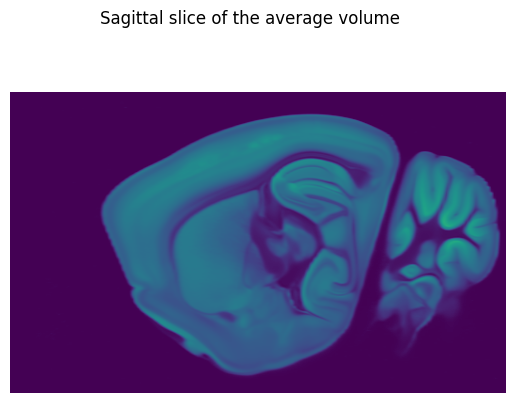

In [4]:
imshow(
    average_array[..., 120].T,
    full_range=True,
    title="Sagittal slice of the average volume",
)

Let's cut it down

In [5]:
focused_area = (
    (average_array.shape[0] // 5 * 2, average_array.shape[0] // 5 * 3),
    (average_array.shape[1] // 5 * 2, average_array.shape[1] // 5 * 3),
    (average_array.shape[2] // 8, average_array.shape[2] // 3),
)
focused_shape = (area_array := np.array(focused_area).T)[1] - area_array[0]
focused_slice = tuple(slice(focus[0], focus[1]) for focus in focused_area)

focused_array = np.zeros_like(average_array)
focused_array[focused_slice] = np.ones(shape=focused_shape)

f"{np.prod(focused_shape):_}"

'638_400'

In [6]:
average_array_cropped = np.where(focused_array, average_array, 0)
average_volume_cropped = vedo.Volume(average_array_cropped)

In [7]:
# show(average_volume_cropped)

## Compare!

In [69]:
neighbours = 3**3
epsilon = 1
point_count = np.prod(focused_shape)
iteration_count = 3

times = {}
errors = {}

for _ in range(iteration_count):
    fitting_proportion = 0.10
    truth_array = np.zeros_like(average_array_cropped)
    truth_array[focused_slice] = np.random.choice(
        [1, 2],
        p=[1 - fitting_proportion, fitting_proportion],
        size=np.prod(focused_shape),
    ).reshape(focused_shape)

    fitting_coordinates = np.nonzero(truth_array == 2)
    fitting_points = np.array(fitting_coordinates).T

    fitting_values = average_array_cropped[fitting_coordinates]

    interpolation_coordinates = np.nonzero(truth_array == 1)
    interpolation_points = np.array(interpolation_coordinates).T

    for kernel in [
        "linear",
        "gaussian",
        "multiquadric",
        "inverse_multiquadric",
        "inverse_quadratic",
    ]:
        logging.info(f"Computing interpolation for {kernel} kernel.")

        interpolator = RBFInterpolator(
            fitting_points,
            fitting_values,
            kernel=kernel,
            neighbors=neighbours,
            epsilon=epsilon,
        )
        start_time = perf_counter()
        interpolated_values = interpolator(interpolation_points[:point_count])
        timing = perf_counter() - start_time

        mae = np.mean(
            np.abs(
                average_array_cropped[
                    tuple(array[:point_count] for array in interpolation_coordinates)
                ]
                - interpolated_values
            )
        )

        if (timings := times.get(kernel)) is not None:
            timings.append(timing)
        else:
            times[kernel] = [timing]

        if (maes := errors.get(kernel)) is not None:
            maes.append(mae)
        else:
            errors[kernel] = [mae]

[2024-09-20 17:16:36] - [    INFO ] - Computing interpolation for linear kernel. (root:33)
[2024-09-20 17:16:56] - [    INFO ] - Computing interpolation for gaussian kernel. (root:33)
[2024-09-20 17:17:17] - [    INFO ] - Computing interpolation for multiquadric kernel. (root:33)
[2024-09-20 17:17:38] - [    INFO ] - Computing interpolation for inverse_multiquadric kernel. (root:33)
[2024-09-20 17:17:59] - [    INFO ] - Computing interpolation for inverse_quadratic kernel. (root:33)
[2024-09-20 17:18:20] - [    INFO ] - Computing interpolation for linear kernel. (root:33)
[2024-09-20 17:18:42] - [    INFO ] - Computing interpolation for gaussian kernel. (root:33)
[2024-09-20 17:19:04] - [    INFO ] - Computing interpolation for multiquadric kernel. (root:33)
[2024-09-20 17:19:26] - [    INFO ] - Computing interpolation for inverse_multiquadric kernel. (root:33)
[2024-09-20 17:19:48] - [    INFO ] - Computing interpolation for inverse_quadratic kernel. (root:33)
[2024-09-20 17:20:09] - 

In [70]:
indentation = " " * 4

print(f"Parameters:")
print(f"{indentation}Neighbours = {neighbours}")
print(f"{indentation}Epsilon = {epsilon}")
print(f"{indentation}Point count = {point_count:_}")
print(f"{indentation}Iteration count = {iteration_count}")

print()

mean_times = np.mean(np.array(list(times.values())), axis=1)
std_times = np.std(np.array(list(times.values())), axis=1)

mean_errors = np.mean(np.array(list(errors.values())), axis=1)
std_errors = np.std(np.array(list(errors.values())), axis=1)

print(f"Results:")
print(f"{indentation}{'Kernel':^20}   {'Time (+/- std)':^18}{' ' * 5}{'MAE':^11}")
for index, kernel in enumerate(times.keys()):
    print(
        f"{indentation}{kernel.replace('_', ' ').capitalize():<20}: "
        f"{mean_times[index]:>6.2f}s "
        f"(+/- {std_times[index]:>5.2f})"
        f"{'-':^5}"
        f"{mean_errors[index]:.0f} "
        f"(+/- {std_errors[index]:.0f})"
    )

Parameters:
    Neighbours = 27
    Epsilon = 1
    Point count = 638_400
    Iteration count = 3

Results:
           Kernel            Time (+/- std)           MAE    
    Linear              :  21.27s (+/-  0.61)  -  325 (+/- 2)
    Gaussian            :  22.01s (+/-  0.77)  -  660 (+/- 4)
    Multiquadric        :  21.37s (+/-  0.65)  -  265 (+/- 1)
    Inverse multiquadric:  21.30s (+/-  0.18)  -  376 (+/- 2)
    Inverse quadratic   :  20.90s (+/-  0.16)  -  487 (+/- 3)


### Hyperparameter tuning

In [40]:
point_count = np.prod(focused_shape)
iteration_count = 3
kernel = "multiquadric"

hyperparameter_df = pd.DataFrame(columns=["neighbours", "epsilon", "time", "mae"])

In [38]:
point_count

6384

In [50]:
for _ in range(iteration_count):
    fitting_proportion = 0.10
    truth_array = np.zeros_like(average_array_cropped)
    truth_array[focused_slice] = np.random.choice(
        [1, 2],
        p=[1 - fitting_proportion, fitting_proportion],
        size=np.prod(focused_shape),
    ).reshape(focused_shape)

    fitting_coordinates = np.nonzero(truth_array == 2)
    fitting_points = np.array(fitting_coordinates).T

    fitting_values = average_array_cropped[fitting_coordinates]

    interpolation_coordinates = np.nonzero(truth_array == 1)
    interpolation_points = np.array(interpolation_coordinates).T
    logging.info(f"Computing interpolation for {kernel} kernel.")

    for neighbours in range(1, 5):
        neighbours = neighbours**3
        for epsilon in range(1):
            epsilon = 10 / 10**epsilon

            logging.info(f"Neighbours: {neighbours} - Epsilon: {epsilon}")

            interpolator = RBFInterpolator(
                fitting_points,
                fitting_values,
                kernel=kernel,
                neighbors=neighbours,
                epsilon=epsilon,
            )
            start_time = perf_counter()
            interpolated_values = interpolator(interpolation_points[:point_count])
            timing = perf_counter() - start_time

            mae = np.mean(
                np.abs(
                    average_array_cropped[
                        tuple(
                            array[:point_count] for array in interpolation_coordinates
                        )
                    ]
                    - interpolated_values
                )
            )

            hyperparameter_df = pd.concat(
                [
                    hyperparameter_df,
                    pd.DataFrame(
                        [[neighbours, epsilon, timing, mae]],
                        columns=hyperparameter_df.columns,
                    ),
                ],
                ignore_index=True,
            )

[2024-09-23 10:15:39] - [    INFO ] - Computing interpolation for multiquadric kernel. (root:17)
[2024-09-23 10:15:39] - [    INFO ] - Neighbours: 1 - Epsilon: 10.0 (root:24)
[2024-09-23 10:15:40] - [    INFO ] - Neighbours: 8 - Epsilon: 10.0 (root:24)
[2024-09-23 10:15:45] - [    INFO ] - Neighbours: 27 - Epsilon: 10.0 (root:24)
[2024-09-23 10:16:05] - [    INFO ] - Neighbours: 64 - Epsilon: 10.0 (root:24)
[2024-09-23 10:17:36] - [    INFO ] - Computing interpolation for multiquadric kernel. (root:17)
[2024-09-23 10:17:36] - [    INFO ] - Neighbours: 1 - Epsilon: 10.0 (root:24)
[2024-09-23 10:17:37] - [    INFO ] - Neighbours: 8 - Epsilon: 10.0 (root:24)
[2024-09-23 10:17:43] - [    INFO ] - Neighbours: 27 - Epsilon: 10.0 (root:24)
[2024-09-23 10:18:04] - [    INFO ] - Neighbours: 64 - Epsilon: 10.0 (root:24)
[2024-09-23 10:19:46] - [    INFO ] - Computing interpolation for multiquadric kernel. (root:17)
[2024-09-23 10:19:46] - [    INFO ] - Neighbours: 1 - Epsilon: 10.0 (root:24)
[20

In [51]:
hyperparameter_df

,neighbours,epsilon,time,mae
0,1,1.00,1.139291,752.080718
1,1,0.10,1.032191,752.080718
2,1,0.01,1.086748,752.080718
3,8,1.00,5.609783,334.219532
4,8,0.10,5.604141,351.620546
5,8,0.01,5.468318,396.776316
6,1,1.00,1.199974,751.919253
7,1,0.10,1.025401,751.919253
8,1,0.01,1.078002,751.919253
9,8,1.00,5.517369,334.234274
